In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
try:
    df = pd.read_csv('../data/complaints.csv')
    print("Dataset loaded successfully.")
    print(f"Shape of the raw dataset: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nDataset Info:")
    df.info()
except FileNotFoundError:
    print("Error: 'complaints.csv' not found in the '../data/' directory.")
    print("Please download the dataset from the provided link and place it there.")

C:\Users\Bisrat\AppData\Local\Temp\ipykernel_11668\4128011227.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/complaints.csv')


Dataset loaded successfully.
Shape of the raw dataset: (9609797, 18)

First 5 rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
mem

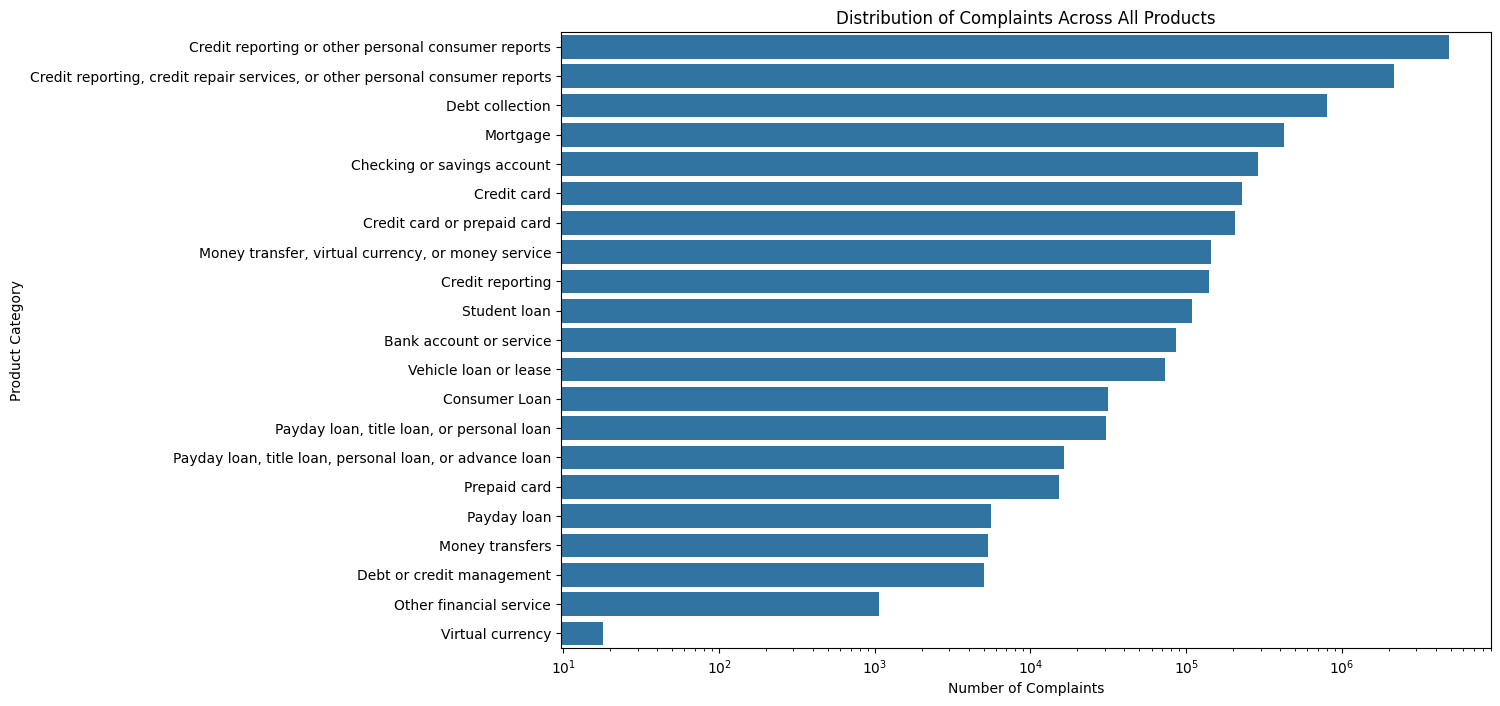

In [4]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Product', data=df, order=df['Product'].value_counts().index)
plt.title('Distribution of Complaints Across All Products')
plt.xlabel('Number of Complaints')
plt.ylabel('Product Category')
plt.xscale('log')
plt.show()

Total complaints: 9609797
Complaints with narrative: 2980756 (31.02%)
Complaints without narrative: 6629041

Statistics for Narrative Word Count:
count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_word_count, dtype: float64


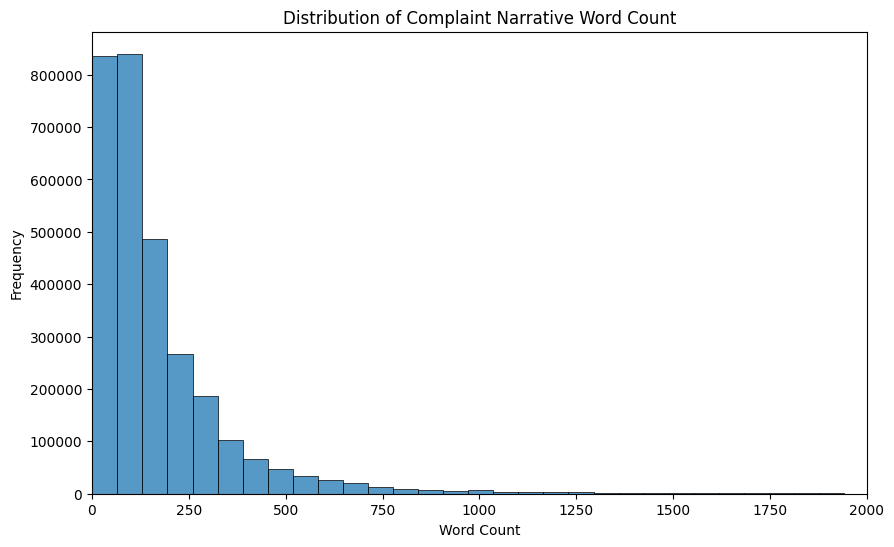

In [5]:
complaints_with_narrative = df['Consumer complaint narrative'].notna().sum()
total_complaints = len(df)
print(f"Total complaints: {total_complaints}")
print(f"Complaints with narrative: {complaints_with_narrative} ({complaints_with_narrative/total_complaints:.2%})")
print(f"Complaints without narrative: {df['Consumer complaint narrative'].isna().sum()}")

df_narratives = df.dropna(subset=['Consumer complaint narrative']).copy()

df_narratives['narrative_word_count'] = df_narratives['Consumer complaint narrative'].apply(lambda x: len(x.split()))

print("\nStatistics for Narrative Word Count:")
print(df_narratives['narrative_word_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_narratives['narrative_word_count'], bins=100, kde=False)
plt.title('Distribution of Complaint Narrative Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 2000)
plt.show()

In [6]:
product_mapping = {
    'Credit card or prepaid card': 'Credit Cards',
    'Checking or savings account': 'Savings Accounts',
    'Payday loan, title loan, or personal loan': 'Personal Loans',
    'Money transfer, virtual currency, or money service': 'Money Transfers',
    'Retail/Purchase': 'Buy Now, Pay Later (BNPL)' # A reasonable proxy from available data
}

target_products = list(product_mapping.keys())

print(f"Filtering for these products: {target_products}")

df_filtered = df_narratives[df_narratives['Product'].isin(target_products)].copy()

print(f"\nShape of the dataset before filtering: {df_narratives.shape}")
print(f"Shape of the dataset after filtering for products: {df_filtered.shape}")

Filtering for these products: ['Credit card or prepaid card', 'Checking or savings account', 'Payday loan, title loan, or personal loan', 'Money transfer, virtual currency, or money service', 'Retail/Purchase']

Shape of the dataset before filtering: (2980756, 19)
Shape of the dataset after filtering for products: (363412, 19)


In [7]:
def clean_narrative_text(text):
    """Cleans the complaint narrative text."""
    # Lowercase text
    text = text.lower()
    # Remove boilerplate introductions (handles variations)
    text = re.sub(r'i am writing to file a complaint about\s?|this complaint is in regards to\s?', '', text, flags=re.IGNORECASE)
    # Remove redacted information commonly represented by 'xx' or 'xxxx'
    text = re.sub(r'\bx{2,}\b', '[REDACTED]', text)
    # Remove special characters, numbers, and punctuation, keeping only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative_text)

# Display a before-and-after example
print("--- Text Cleaning Example ---")
pd.set_option('display.max_colwidth', 400)
display(df_filtered[['Consumer complaint narrative', 'cleaned_narrative']].head(1))

--- Text Cleaning Example ---


,Consumer complaint narrative,cleaned_narrative
12532,"I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. \n\nI went into the branch and was told they couldn't help and had to phone the customer service for help. I did this and was told I was helped gave all the info for the time terminal id aact # s, XXXX was able to find the transaction and give me this info, he said the dispute w...",i made the mistake of using my wellsfargo debit card to depsit funds into atm machine outside their branch i went into the branch and was told they couldnt help and had to phone the customer service for help i did this and was told i was helped gave all the info for the time terminal id aact s was able to find the transaction and give me this info he said the dispute would take a few days i wa...


In [8]:
df_filtered['Product'] = df_filtered['Product'].map(product_mapping)

# Select and rename columns for clarity
final_df = df_filtered[['Complaint ID', 'Date received', 'Product', 'Consumer complaint narrative', 'cleaned_narrative']].copy()
final_df.rename(columns={'Complaint ID': 'complaint_id', 'Date received': 'date', 'Product': 'product', 'Consumer complaint narrative': 'original_narrative'}, inplace=True)

# Save the cleaned and filtered dataset
output_path = '../data/filtered_complaints.csv'
final_df.to_csv(output_path, index=False)

print(f"Cleaned and filtered dataset saved to: {output_path}")
print(f"Final dataset shape: {final_df.shape}")
display(final_df.head())

Cleaned and filtered dataset saved to: ../data/filtered_complaints.csv
Final dataset shape: (363412, 5)


,complaint_id,date,product,original_narrative,cleaned_narrative
12532,14061897,2025-06-13,Savings Accounts,"I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. \n\nI went into the branch and was told they couldn't help and had to phone the customer service for help. I did this and was told I was helped gave all the info for the time terminal id aact # s, XXXX was able to find the transaction and give me this info, he said the dispute w...",i made the mistake of using my wellsfargo debit card to depsit funds into atm machine outside their branch i went into the branch and was told they couldnt help and had to phone the customer service for help i did this and was told i was helped gave all the info for the time terminal id aact s was able to find the transaction and give me this info he said the dispute would take a few days i wa...
14562,13960106,2025-06-08,Savings Accounts,Got locked out of my account because I was trying to link my bank account to my XXXX and called customary service to get my account unlocked. Got told that I needed an account number and or debit card number which I dont have since I cant access my account and the delivery date for card hadnt arrived. So I suggested using my social security number as verification which they agreed. I was told ...,got locked out of my account because i was trying to link my bank account to my and called customary service to get my account unlocked got told that i needed an account number and or debit card number which i dont have since i cant access my account and the delivery date for card hadnt arrived so i suggested using my social security number as verification which they agreed i was told to provi...
17030,13976941,2025-06-09,Savings Accounts,"I am in the process of applying for a mortgage, and a recent overdraft fee is preventing my prequalification. I respectfully requested a one-time courtesy refund at my branch and by phone, but was denied despite being a loyal customer. XXXX seeking help with getting it removed so I can move forward with housing for my family.",i am in the process of applying for a mortgage and a recent overdraft fee is preventing my prequalification i respectfully requested a onetime courtesy refund at my branch and by phone but was denied despite being a loyal customer seeking help with getting it removed so i can move forward with housing for my family
17118,13974625,2025-06-09,Money Transfers,This all happened in XXXX and XXXX was taken from my Wells Fargo account I opened the XXXX XXXX account all on the same day which was in XXXX no it was in XXXX XXXX savings XXXX checking in the last part of of XX/XX/XXXX of XXXX or and I received nothing they lied about the date that I opened my savings account that I was transferring on wire transfer from Wells Fargo {$200000.00} {$99000.00}...,this all happened in and was taken from my wells fargo account i opened the account all on the same day which was in no it was in savings checking in the last part of of of or and i received nothing they lied about the date that i opened my savings account that i was transferring on wire transfer from wells fargo and some change in checking and savings i file complaints after complaints after ...
21658,13810547,2025-05-30,Savings Accounts,"USAA SAVINGS BANK DECIDED TO CLOSE MY ACCOUNT WITHOUT NOTICE, I HAVE A MEDICAL HEALTH CONDITION AND I NEED MY FUNDS RELEASED TO ME THEY STATED IT CAN TAKE 60 DAYS BUT I CAN NOT WAIT THIS LONG I HAVE FINANCIAL OBLIGATION AND THEY CAN NOT WITHHOLD MY FUNDS WHICH ALL OF IT IS FROM MY EMPLOYER DIRECT DEPOSIT. THIS IS UNFAIR AND INHUMANE",usaa savings bank decided to close my account without notice i have a medical health condition and i need my funds released to me they stated it can take days but i can not wait this long i have financial obligation and they can not withhold my funds which all of it is from my employer direct deposit this is unfair and inhumane
